In [4]:
import scipy
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pysptools
import pysptools.spectro
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from scipy.linalg import pinv

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Define the visualization function
def visualize_hyperspectral_image(image_tensor, wavelength_index, wavelengths):
    assert len(image_tensor.shape) == 3, "Image tensor must be 3-dimensional"
    A, B, C = image_tensor.shape
    assert 0 <= wavelength_index < C, "Wavelength index out of bounds"

    variation = np.var(image_tensor[:,:,0:40], axis=2)
    flat_indices = np.argpartition(variation.flatten(), -3)[-3:]
    top_var_pixel_indices = np.array(np.unravel_index(flat_indices, variation.shape)).T

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor[:, :, wavelength_index], cmap='gray')
    plt.title(f'Hyperspectral Image at Wavelength {wavelength_index}')
    plt.colorbar(label='Intensity')
    
    colors = ['r', 'g', 'b']
    for i, (x, y) in enumerate(top_var_pixel_indices):
        plt.scatter(y, x, color=colors[i], s=100, marker='x', label=f'Pixel {i+1}')

    plt.legend()

    plt.subplot(1, 2, 2)
    for i, (x, y) in enumerate(top_var_pixel_indices):
        plt.plot(wavelengths, image_tensor[x, y, :], color=colors[i], label=f'Pixel {x},{y}')

    plt.title('Spectral Signatures')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

    plt.tight_layout()
    plt.show()

def init_interactive_visualization(image_tensor, wavelengths):
    def find_rgb_indices(wavelengths, rgb_wavelengths=[630, 540, 510]):
        rgb_indices = []
        for wl in rgb_wavelengths:
            index = np.abs(wavelengths - wl).argmin()
            rgb_indices.append(index)
        return rgb_indices
    
    rgb_indices = find_rgb_indices(wavelengths)
    
    def generate_rgb_image(image_tensor, rgb_indices):
        rgb_image = np.zeros((image_tensor.shape[0], image_tensor.shape[1], 3))
        for i, idx in enumerate(rgb_indices):
            rgb_image[:, :, i] = normalize(image_tensor[:, :, idx])
        rgb_image = rgb_image
        return rgb_image
    
    rgb_image = generate_rgb_image(image_tensor, rgb_indices)
    
    colors = list(mcolors.TABLEAU_COLORS.values()) 
    color_index = 0  
    
    def onclick(event):
        nonlocal color_index
        ix, iy = int(event.xdata), int(event.ydata)
        spectrum = image_tensor[iy, ix, :]
        
        ax1.plot(ix, iy, 'x', color=colors[color_index % len(colors)], markersize=10)
        ax2.plot(wavelengths, spectrum, color=colors[color_index % len(colors)], label=f'Pixel ({ix}, {iy})')
        ax2.set_title('Spectral Signatures')
        ax2.set_xlabel('Wavelength')
        ax2.set_ylabel('Intensity')
        ax2.legend()
        
        fig.canvas.draw()
        
        color_index += 1  
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(rgb_image)
    ax1.set_title('RGB Representation of Hyperspectral Image')
    
    fig.canvas.mpl_connect('button_press_event', onclick)
    
    plt.show()

def save_optimization_data(img_ref, reference_point, coef_list, scattering_params, errors, t1, time_taken, folder):
    """
    Used after running the optimisation script/notebook to be used later by the Neural Network
    """
    img_ref = torch.from_numpy(img_ref)
    reference_point = torch.from_numpy(reference_point)
    coef_list = torch.from_numpy(coef_list)
    scattering_params = torch.from_numpy(scattering_params)
    errors = torch.from_numpy(errors)
    t1 = torch.from_numpy(t1)
    time_taken = torch.from_numpy(np.array([time_taken]))
    
    path = "/workspace/volumes/m2/data/ba_hyperspectral_segmentation/src/dataset/hyperprobe_biopsies"
    
    if not os.path.exists(path): os.mkdir(path)
    path = path + folder 
    if not os.path.exists(path): os.mkdir(path)
    
    torch.save(img_ref, path+'/img_ref.pt')
    torch.save(reference_point, path+'/reference_point.pt')
    torch.save(coef_list, path + '/coef_list.pt')
    torch.save(scattering_params, path + '/scattering_params.pt')
    torch.save(errors, path + '/errors.pt')
    torch.save(t1, path + '/t1.pt')
    torch.save(time_taken, path + '/time_taken.pt')

In [5]:
%matplotlib widget

In [6]:
os.chdir("..")

In [7]:
from optimisation_helicoid import read_molecules_creatis, read_molecules_cytochrome_cb

PATH:  /workspace/volumes/m2/data/ba_hyperspectral_segmentation/src


# Visualize Wavelengths

In [8]:
#filename = "/home/kevin/hyperprobe_biopsies/Biopsy_S2_reflectance.mat"
biopsy_name = "Biopsy_S1_reflectance"
filename = "/workspace/volumes/m2/data/ba_hyperspectral_segmentation/src/dataset/hyperprobe_biopsies/" + biopsy_name + ".mat"
with h5py.File(filename, 'r') as f:
    data = np.array(f['Ref_hyper'])
data_transposed = np.transpose(data)
data_transposed.shape
data_transposed[data_transposed<=0] = 10**-3
data_transposed = F.avg_pool2d(torch.tensor(data_transposed).permute(2, 0, 1).unsqueeze(0), kernel_size=4, stride=4).squeeze(0).permute(1, 2, 0).numpy()
img = data_transposed
data_transposed.shape
wavelengths = np.linspace(510,900,79)
wavelengths

array([510., 515., 520., 525., 530., 535., 540., 545., 550., 555., 560.,
       565., 570., 575., 580., 585., 590., 595., 600., 605., 610., 615.,
       620., 625., 630., 635., 640., 645., 650., 655., 660., 665., 670.,
       675., 680., 685., 690., 695., 700., 705., 710., 715., 720., 725.,
       730., 735., 740., 745., 750., 755., 760., 765., 770., 775., 780.,
       785., 790., 795., 800., 805., 810., 815., 820., 825., 830., 835.,
       840., 845., 850., 855., 860., 865., 870., 875., 880., 885., 890.,
       895., 900.])

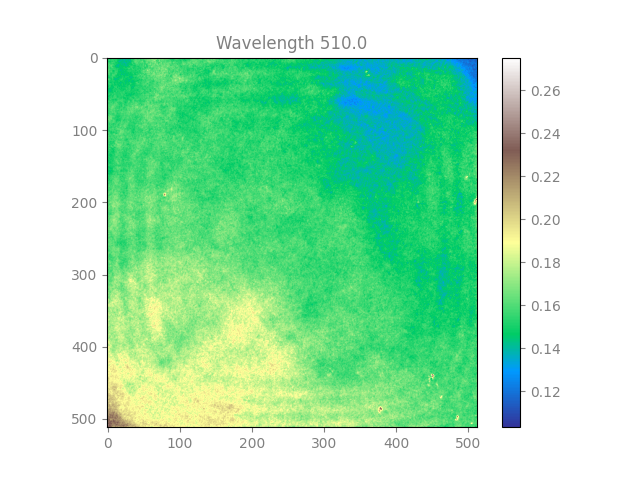

In [9]:
for i in range(len(wavelengths)):
    plt.figure()
    plt.imshow(data_transposed[:,:,i])
    plt.colorbar()
    plt.title("Wavelength " + str(wavelengths[i]))
    break

In [10]:
data_transposed = data_transposed
semisynthetic_rgb = np.concatenate((normalize(data_transposed[:,:,23][:,:,np.newaxis]), normalize(data_transposed[:,:,6][:,:,np.newaxis]), normalize(data_transposed[:,:,0][:,:,np.newaxis])),axis=2)
plt.imshow(semisynthetic_rgb)

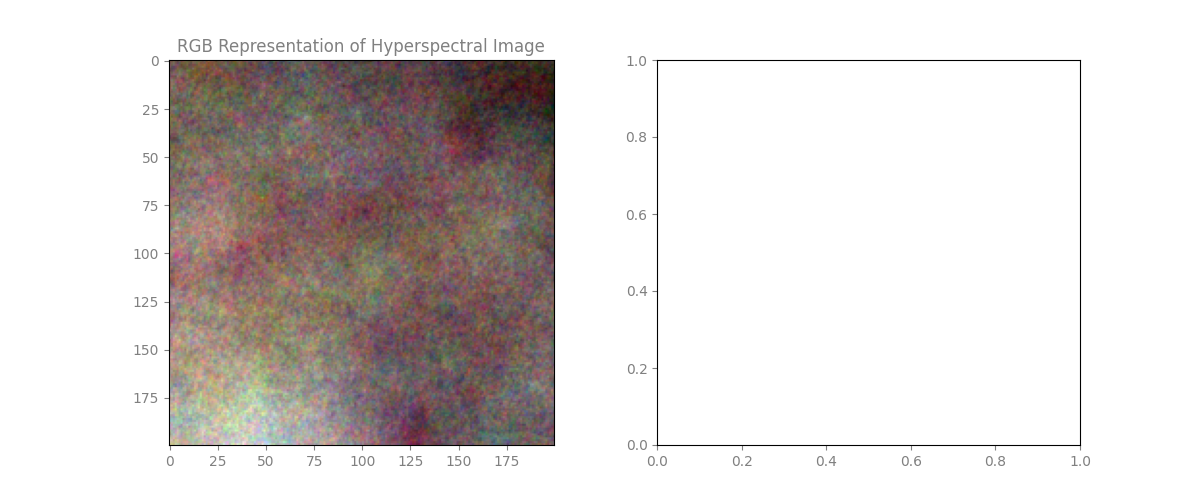

In [11]:
init_interactive_visualization(data_transposed[150:350, 150:350, :], wavelengths)

# Scattering Model

In [12]:
from optimisation_helicoid import helicoid_optimisation_scattering, helicoid_optimisation_ti_parallel

wavelengths = np.linspace(510,900,79)



In [ ]:
import scipy.io
import blosc
import pickle
from pathlib import Path
# two modes: different range and different wavelengths
#mode = "_oxcco2_water"
mode = "_all"

if mode == "_oxcco1" or mode == "_oxcco2" or mode == "_oxcco2_water":
    left_cut = 740
    right_cut = 910
elif mode == "_oxcco2_2":
    left_cut = 700
    right_cut = 910
elif mode == "_oxcco2_3":
    left_cut = 740
    right_cut = 910
elif mode == "_oxcco4":
    left_cut = 580
    right_cut = 910
elif mode == "_no_water":
    left_cut = 500
    right_cut = 910 
elif mode == "_all":
    left_cut = 500
    right_cut = 910         
else:
    error("Nonexistent mode")
    
molecules_cyto, x_cyto = read_molecules_cytochrome_cb(left_cut, right_cut, wavelengths)
molecules, x = read_molecules_creatis(left_cut, right_cut, x_waves=wavelengths)
y_c_oxy, y_c_red, y_b_oxy, y_b_red = molecules_cyto #, y_water, y_fat = molecules
y_hb_f, y_hbo2_f, y_coxa, y_creda, y_fat, y_water = molecules

if mode == "_oxcco1":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda))))      
elif mode == "_oxcco2":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_fat))))        
elif mode == "_oxcco2_2":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_fat),
                                np.asarray(y_water))))         
elif mode == "_oxcco3" or mode == "_oxcco4" or mode == "_oxcco2_water":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_water),
                                np.asarray(y_fat))))
elif mode == "_no_water":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_c_oxy),
                                np.asarray(y_c_red),
                                np.asarray(y_b_oxy),
                                np.asarray(y_b_red),
                                np.asarray(y_fat))))        
elif mode == "no_fat":
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_c_oxy),
                                np.asarray(y_c_red),
                                np.asarray(y_b_oxy),
                                np.asarray(y_b_red),
                                np.asarray(y_water))))      
elif mode=="" or mode == "_all":    
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda),
                                np.asarray(y_c_oxy),
                                np.asarray(y_c_red),
                                np.asarray(y_b_oxy),
                                np.asarray(y_b_red),
                                np.asarray(y_water),
                                np.asarray(y_fat))))
else:
    error("Mode nonexistent")

#######
 #for biopsy_sample in biopsy_samples:
biopsy_name = "Biopsy_S1_reflectance"
filename = "/workspace/volumes/m2/data/ba_hyperspectral_segmentation/src/dataset/hyperprobe_biopsies/" + biopsy_name + ".mat"
# with h5py.File(filename, 'r') as f:
#     data = np.array(f['Ref_hyper'])

import json
import os

def compress_large_array(data, chunk_size=1000, output_dir="compressed_data"):
    """
    Compress large numpy array into blosc chunks
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate chunks
    total_pixels = data.shape[0] * data.shape[1]
    chunks = [(i, min(i + chunk_size, total_pixels)) 
              for i in range(0, total_pixels, chunk_size)]
    
    # Save metadata
    metadata = {
        'shape': data.shape,
        'dtype': str(data.dtype),
        'chunks': len(chunks)
    }
    
    with open(f"{output_dir}/metadata.json", 'w') as f:
        json.dump(metadata, f)
    
    # Compress chunks
    for i, (start, end) in enumerate(chunks):
        chunk_data = data.reshape(total_pixels, -1)[start:end]
        compressed = blosc.pack_array(chunk_data)
        with open(f"{output_dir}/chunk_{i}.blosc", 'wb') as f:
            f.write(compressed)
    
    return metadata

def decompress_large_array(input_dir):
    """
    Decompress blosc chunks back into numpy array
    """
    # Load metadata
    with open(f"{input_dir}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    # Initialize output array
    shape = tuple(metadata['shape'])
    dtype = np.dtype(metadata['dtype'])
    result = np.zeros(shape, dtype=dtype)
    
    # Load and decompress chunks
    total_pixels = shape[0] * shape[1]
    result_flat = result.reshape(total_pixels, -1)
    chunk = np.empty(shape=shape, dtype=dtype)

    for i in range(metadata['chunks']):
        with open(f"{input_dir}/chunk_{i}.blosc", 'rb') as f:
            compressed = f.read()
        # chunk = blosc.unpack_array(compressed)
        
        blosc.decompress_ptr(compressed, chunk.__array_interface__["data"][0])
        # chunk = np.as_array(chunk)
        start = i * chunk.shape[0]
        end = start + chunk.shape[0]
        result_flat[start:end] = chunk
    
    return result

def decompress_chunks(self, base_path):
    """
    Decompresses multiple blosc chunks into single array.
    
    Args:
        base_path: Path to directory containing chunks and metadata
        
    Returns: 
        Reconstructed numpy array
    """
    # Load metadata
    with open(f"{base_path}/metadata.json", "r") as f:
        meta = json.load(f)
        shape = tuple(meta['shape'])
        dtype = np.dtype(meta['dtype'])
        num_chunks = meta['chunks']
    
    # Initialize output array
    result = np.empty(shape=shape, dtype=dtype)
    total_pixels = shape[0] * shape[1]
    result_flat = result.reshape(total_pixels, -1)
    
    # Load and place chunks
    for i in range(num_chunks):
        chunk_path = Path(f"{base_path}/chunk_{i}.blosc")
        with chunk_path.open("rb") as f:
            chunk_meta = pickle.load(f)
            data = f.read()
            chunk_array = np.empty(shape=chunk_meta[0], dtype=chunk_meta[1])
            blosc.decompress_ptr(data, chunk_array.__array_interface__["data"][0])
            
            # Calculate chunk position
            start = i * chunk_array.shape[0]
            end = start + chunk_array.shape[0]
            result_flat[start:end] = chunk_array
            
    return result.reshape(shape)

def decompress_file(self, path):
        """
        Decompresses a blosc file.

        Args:
            path: File to the blosc data.

        Returns: Decompressed array data.
        """
        res = {}

        with path.open("rb") as f:
            meta = pickle.load(f)
            shape, dtype = meta
            data = f.read()
            array = np.empty(shape=shape, dtype=dtype)
            blosc.decompress_ptr(data, array.__array_interface__["data"][0])

            res = array

        return res
# data1 = compress_large_array(data, chunk_size=1000, output_dir="compressed_data")
data = decompress_large_array("biopsy_1_compressed")
# serialized_data = blosc.pack_array(data)
    
# Save the serialized data as a .blosc file
# with open("test_blosc", 'wb') as f:
#     f.write(serialized_data)

# loaded_data = scipy.io.loadmat(filename)
# data = loaded_data['Ref_hyper']
# data = np.array(data)
data_transposed = np.transpose(data)
data_transposed.shape
data_transposed[data_transposed<=0] = 10**-3
data_transposed = F.avg_pool2d(torch.tensor(data_transposed).permute(2, 0, 1).unsqueeze(0), kernel_size=8, stride=8).squeeze(0).permute(1, 2, 0).numpy()

mean_biopsy_s1 = np.mean(data_transposed[150:350, 150:350, :].reshape(-1, data_transposed.shape[-1]), axis=0)
#######

#for biopsy_name in [("Biopsy_S1_reflectance","4"), ("Biopsy_S2_reflectance","4")]:
#for biopsy_name in [("Biopsy_S11_reflectance","4
for biopsy_name in [("Biopsy_S2_reflectance","4")]:#, 
                    #("Biopsy_S4_fov1_reflectance", "4"), 
                    #("Biopsy_S4_fov2_reflectance", "4"),
                    #("Biopsy_S5_reflectance", "4"),
                    #("Biopsy_S7_reflectance", "2"),
                    #("Biopsy_S8_reflectance", "3"),
                    #("Biopsy_S9_reflectance", "4"),
                    #("Biopsy_S10_reflectance", "2"),
                    #("Biopsy_S11_reflectance","4")]:
    filename = "/workspace/volumes/m2/data/ba_hyperspectral_segmentation/src/dataset/hyperprobe_biopsies/" + biopsy_name[0] + ".mat"
    print(biopsy_name)
    print(filename)
    t1 = torch.load("/workspace/volumes/m2/data/ba_hyperspectral_segmentation/src/dataset/hyperprobe_biopsies/t1.pt").numpy()
    
    # with h5py.File(filename, 'r') as f:
    #     data = np.array(f['Ref_hyper'])
    # data1 = compress_large_array(data, chunk_size=1000, output_dir="biopsy_2_compressed")
    data = decompress_large_array("biopsy_2_compressed")
    data_transposed = np.transpose(data)
    data_transposed.shape
    data_transposed[data_transposed<=0] = 10**-3
    data_transposed = F.avg_pool2d(torch.tensor(data_transposed).permute(2, 0, 1).unsqueeze(0), kernel_size=4, stride=4).squeeze(0).permute(1, 2, 0).numpy()

    img = data_transposed
    time_taken = -1
    
    coarseness=1
    # Combine probes to filter out noise and enhance contrast with log
    # img[::coarseness,::coarseness,:] : reduces spatial resolution of img with stepsize=coarseness while keeping all spectral bands
    # img_ref = -np.log(img[::coarseness,::coarseness,:] / mean_biopsy_s1)[:,:,np.in1d(wavelengths,x)]
    # b = img_ref.reshape(-1, img_ref.shape[-1])
    # errors, coef_list, scattering_params, errors_scatter = helicoid_optimisation_ti_parallel(t1, b, M, x)
    # coef_list = coef_list.reshape(img.shape[0], img.shape[1], -1)
    # scattering_params = scattering_params.reshape(img.shape[0], img.shape[1], -1)
    print("done")
    # errors = np.array([])
    #coef_list, scattering_params, errors, a_t1, b_t1, img_ref, time_taken = helicoid_optimisation_scattering(img, None, M, x, coarseness=1, wavelength=wavelengths, reference_signal=mean_biopsy_s1)
    
    # save_optimization_data(img_ref, np.array([128,128]), coef_list, scattering_params, errors, t1, time_taken, biopsy_name[0]+"_s1_normalized_" + str(right_cut) + "_t1_fixed" + mode)

AttributeError: module 'numpy' has no attribute 'as_array'

In [16]:
# coef_list.shape
img.shape

(512, 512, 79)